## Evaluation of Bayes model compared to simple average
This notebook uses some datasets and compares the performance of 2 models.
- `loo`: The leave-one-subject-out model which simply averages the connectivity weights
- `bayes`: Uses the leave-one-subject-out manner but do weighted average across subjects accroding to their `coef_var`


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
from statannotations.Annotator import Annotator
import Functional_Fusion.dataset as fdata
import glob
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

In [2]:
def heatmap_annotate(df_to_plot, ds_order, ax, column=['train_dataset'], row=['eval_dataset'], value=['R_eval'], cmap='inferno', vmin=0, vmax=0.5):
    ds_order_y = [ds for ds in ds_order if 'Fusion' not in ds]
    V = pd.pivot_table(df_to_plot, columns=column, index=row, values=value)
    V = V.reindex(ds_order_y, axis=0)
    V = V.reindex(ds_order, level=1, axis=1)

    sns.heatmap(V.values, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax, 
                xticklabels=V.columns.get_level_values(1).values, 
                yticklabels=V.index.values, square=True, ax=ax)
    
    if len(ds_order_y) != len(ds_order):
        ax.axvline(len(ds_order_y), color='k', linewidth=2)

    return ax

### Bayes using half estimation

In [3]:
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = []
    for eval_ds in dataset_list:
        if eval_ds!=dataset_name:
            if (eval_ds!='Fus') & (eval_ds!='Language'):
                eval_data.append(eval_ds)
            elif eval_ds=='Language':
                eval_data.append('Languagelocalizer_cond')

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg"],methods=['L2reghalf'],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df])

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo"],methods=['L2reghalf'],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer_cond'],cerebellum='MNISymC3')
    df['model'] = dataset_name+"-loo"
    df_all = pd.concat([df_all, df])

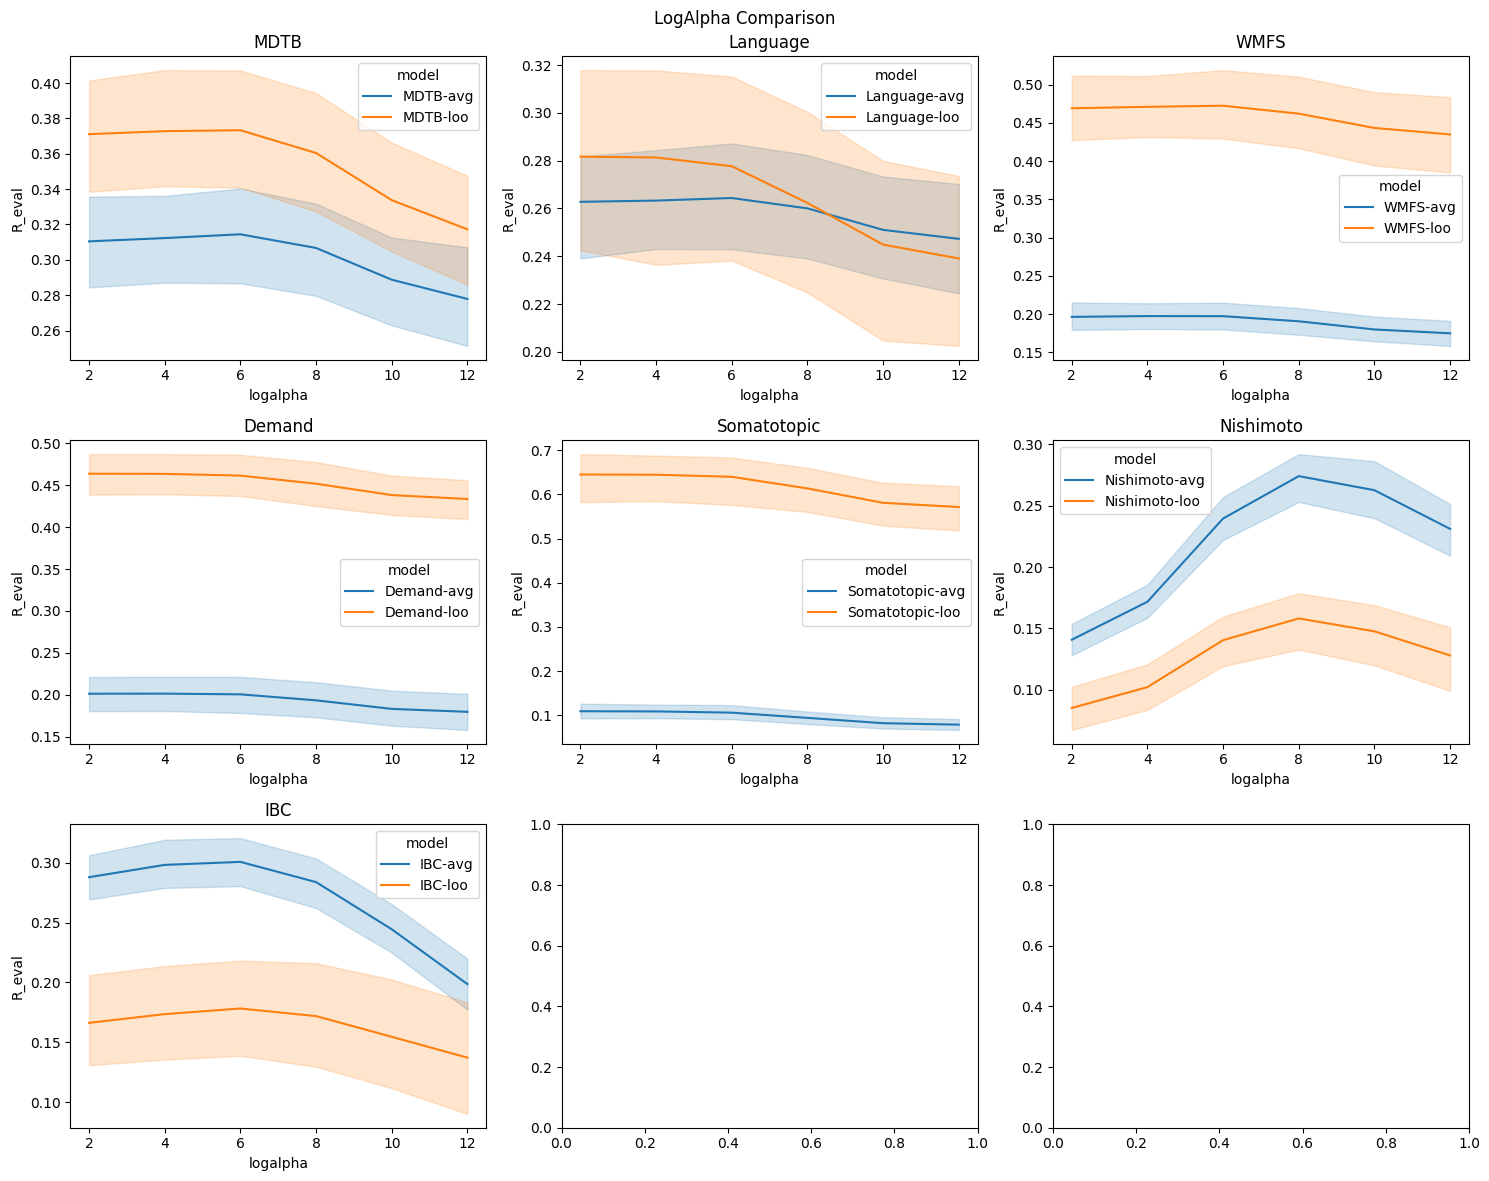

In [4]:
plt.subplots(int(np.ceil(len(dataset_list)/3)),3,figsize=(15,int(np.ceil(len(dataset_list)/3))*4))
plt.suptitle('LogAlpha Comparison')
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/3)),3,d+1)
    df_to_eval = df_all[df_all['train_dataset'] == dataset]
    sns.lineplot(data=df_to_eval, y='R_eval', x='logalpha', hue='model', palette="tab10")
    plt.title(dataset)
plt.tight_layout()

In [4]:
A = pd.pivot_table(df_all,index=['train_dataset'],columns=['logalpha'],values=['R_eval']).reindex(dataset_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_all['isbest'] = (df_all.logalpha.values == bestla.loc[df_all.train_dataset].values.flatten()) | (df_all.train_dataset.str.contains('Fus'))

R_eval                                                  
logalpha           2.0       4.0       6.0       8.0       10.0      12.0
train_dataset                                                            
MDTB           0.322588  0.324417  0.326227  0.317460  0.297771  0.285762
Language       0.265475  0.265860  0.266272  0.260368  0.250181  0.246142
WMFS           0.232871  0.234007  0.234105  0.226940  0.215164  0.209676
Demand         0.282139  0.282134  0.280919  0.272982  0.261734  0.257882
Somatotopic    0.144992  0.144613  0.141666  0.128878  0.115497  0.111795
Nishimoto      0.137900  0.168181  0.234575  0.268315  0.256887  0.225934
IBC            0.275766  0.285738  0.288460  0.272626  0.235441  0.192471

,best_logalpha
train_dataset,
MDTB,6.0
Language,6.0
WMFS,6.0
Demand,2.0
Somatotopic,2.0
Nishimoto,8.0
IBC,6.0


### Bayesian Integration
Assuming that true connectivity weights are:
$$ W_i = W_u + W_d + W_{s_i} $$
our measurements are:
$$ \hat{W_i} = sc_i (W_u + W_d + W_{s_i} + \epsilon_i) $$
thus, the variance of the measurements are (assuming independence):
$$ Var(\hat{W_i}) = sc_i^2 (V_u + V_d + V_s + V_{m_i}) $$

first, we should un-scale the measurements to obtain same level of signal:
$$ W_n = \frac{\hat{W_i}}{sc_i} $$
$$ Var(W_n) = V_u + V_d + V_s + V_{m_i} $$

then, integrate using the noise variance:
$$ \sum \frac{1}{V_d + V_s + V_{m_i}} W_n $$

where the effective integration weights are:
$$ \sum \frac{1}{sc_i (V_d + V_s + V_{m_i})} \hat{W_i} $$

In [8]:
# Load avg fusion
df_fuse_avg = rm.comb_eval(models=["Fus-lodo-avg"],methods=['L2reghalf'],eval_data=["all"],cerebellum='MNISymC3')
df_fuse_avg['train_dataset'] = 'Fusion-avg'

# Load bayes fusion
df_fuse_bayes = rm.comb_eval(models=["Fus-lodo-bayes"],methods=['L2reghalf'],eval_data=["all"],cerebellum='MNISymC3')
df_fuse_bayes['train_dataset'] = 'Fusion-bayes'

df_best = df_all[df_all['isbest']].copy()

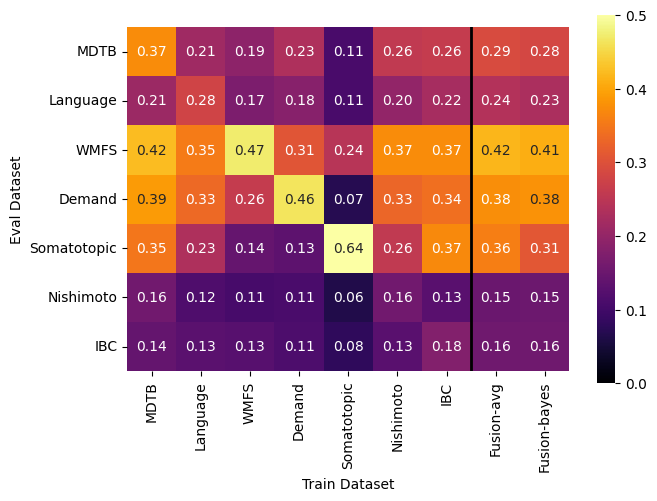

In [ ]:
plt.figure(figsize=(7, 5))
ds_order = dataset_list + ['Fusion-avg', 'Fusion-bayes']
df_to_plot = pd.concat([df_best, df_fuse_avg, df_fuse_bayes])
ax = heatmap_annotate(df_to_plot, ds_order, ax=plt.gca())
ax.set_xlabel('Train Dataset')
ax.set_ylabel('Eval Dataset')
plt.tight_layout()

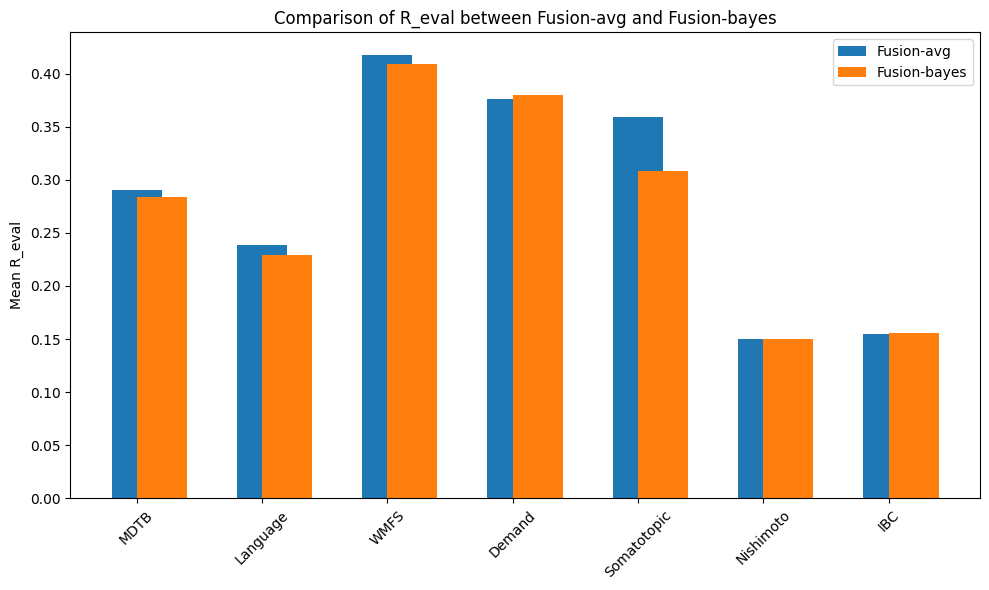

Fusion-avg has a greater mean R_eval.
Dataset: MDTB, T-statistic: 2.5614, P-value: 0.0175
Dataset: Language, T-statistic: 2.1506, P-value: 0.0471
Dataset: WMFS, T-statistic: 2.8694, P-value: 0.0117
Dataset: Demand, T-statistic: -3.9633, P-value: 0.0003
Dataset: Somatotopic, T-statistic: 5.9006, P-value: 0.0006
Dataset: Nishimoto, T-statistic: -0.2951, P-value: 0.7798
Dataset: IBC, T-statistic: -0.2852, P-value: 0.7808


In [22]:
# Merge the dataframes
merged_df = pd.merge(df_fuse_avg, df_fuse_bayes, on=['eval_dataset', 'eval_subj'], suffixes=('_avg', '_bayes'))

# Group by eval_dataset and calculate the mean R_eval for each group
grouped_avg = merged_df.groupby('eval_dataset')['R_eval_avg'].mean().reindex(dataset_list)
grouped_bayes = merged_df.groupby('eval_dataset')['R_eval_bayes'].mean().reindex(dataset_list)

# Plot the results
plt.figure(figsize=(10, 6))
x = range(len(dataset_list))
plt.bar(x, grouped_avg, width=0.4, label='Fusion-avg', align='center')
plt.bar(x, grouped_bayes, width=0.4, label='Fusion-bayes', align='edge')
plt.xticks(x, dataset_list, rotation=45)
plt.ylabel('Mean R_eval')
plt.title('Comparison of R_eval between Fusion-avg and Fusion-bayes')
plt.legend()
plt.tight_layout()
plt.show()

# Print t-test results
if grouped_avg.mean() > grouped_bayes.mean():
    print("Fusion-avg has a greater mean R_eval.")
else:
    print("Fusion-bayes has a greater mean R_eval.")

# Perform paired t-test for each dataset separately
for dataset in dataset_list:
    dataset_data = merged_df[merged_df['eval_dataset'] == dataset]
    t_stat, p_value = ttest_rel(dataset_data['R_eval_avg'], dataset_data['R_eval_bayes'])
    print(f"Dataset: {dataset}, T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")